# Variant Analysis
This notebook contains developmental code for the analysis of intra-host genomic variants from Sars-Cov-2 samples. 

In [1]:
import collections  # hash maps and counters
import re  # regular expressions
import numpy as np  # linear algebra
import pandas as pd  # data processing
from path import Path  # file handling
import plotly.graph_objects as go  #viz

In [2]:
pd.__version__

'1.0.5'

## Main Observations
* Not all samples in `analysis` can be found in the metadata
* Sample ID naming convention is **not consistent** between `analysis` and metadata
    * consolidated inconsistency using regex
    * 250 samples remain unaccounted for, what should we do?
* Few duplicate sample IDs are found across different runs in `analysis`
* How do we define synonymous vs non-synonymous iSNVs when `ALT_AA` has special values such as `NaN` and `*`?



## TODO
* load variants for all samples into one dataframe
* Visualize variants across different locations
* Visualize variant prevalence over time
* `ALT_AA` is unknown ONLY if NaN
    * this accounts for insertions and deletion - important to look at!!
* `ALT_AA=*` stands for a stop codon
* Use most recent `*.tsv` for duplicated samples in `variants_df`
* use KGs `COVID_sequencing_summary` on Google Doc to account for IDs with old naming conventions



## Questions
* How do define a specific variant?
    * **mutation: any base change at a given region and position**
    * **variant: a specific base change at a given region and position**
    * does alternate frequency `ALT_FREQ` matter in any way?
        * lets not worry about it now
* Account for missing IDs:
    * can we assume that `MEX` and `TIJ` are synonymous? This would account for 26 additional missing samples
    * IGNORE location, match by ID only (check for duplicate IDs across different locations)

In [3]:
variant_pths = !find /home/gk/analysis/ -type f -path '*variants*' -name '*.tsv'
variant_pths = [Path(p) for p in variant_pths]
print(f'{len(variant_pths)} different samples with variants files')

2820 different samples with variants files


In [4]:
variant_ids = [pth.basename().split('_')[0] for pth in variant_pths]
print(f'Variant analysis contains results from {len(set(variant_ids))} unique sample IDs')

Variant analysis contains results from 2813 unique sample IDs


In [5]:
data = list(zip(*[variant_ids, variant_pths]))

variants_df = pd.DataFrame(data=data, columns=['ID', 'PATH'])

print(variants_df.shape)
variants_df.head()

(2820, 2)


,ID,PATH
0,10idSEARCH0103SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...
1,41idSEARCH0134SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...
2,02idSEARCH0095SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...
3,12idSEARCH0105SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...
4,28idSEARCH0121SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...


In [6]:
meta_fn = Path('/home/al/code/covid/HCoV-19-Genomics/metadata.csv')

meta_df = pd.read_csv(meta_fn)

samples = meta_df['ID'].unique()
labs = meta_df['originating_lab'].unique()
locations = meta_df['location'].unique()
print(f'Metadata contains {len(samples)} total samples from {len(labs)} different labs across {len(locations)} different locations')
print(locations)

Metadata contains 1195 total samples from 8 different labs across 8 different locations
['USA/California/San Diego' 'Jordan/Amman' 'Jordan/Irbid'
 'USA/Louisiana/New Orleans' 'USA/California/Imperial'
 'USA/California/Cruise_Ship_2' 'USA/California/Cruise_Ship_1'
 'MEX/BajaCalifornia/Tijuana']


**Issue: There are $2562 - 1195 = 1373$ samples that are missing metadata information**

In [7]:
mrgd_df = pd.merge(variants_df, meta_df, on='ID', how='inner')
print(mrgd_df.shape)
mrgd_df.head()

(574, 10)


,ID,PATH,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab
0,SEARCH-0813-SAN,/home/gk/analysis/2020.06.28.hCoV19/variants/i...,MT811388,EPI_ISL_483376,2020-03-31,USA/California/San Diego,100.0,4182.51,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...
1,SEARCH-0705-SAN,/home/gk/analysis/2020.06.28.hCoV19/variants/i...,MT811327,EPI_ISL_483314,2020-03-29,USA/California/San Diego,100.0,6468.52,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...
2,SEARCH-0709-SAN,/home/gk/analysis/2020.06.28.hCoV19/variants/i...,MT811330,EPI_ISL_483317,2020-03-31,USA/California/San Diego,100.0,12224.10,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...
3,SEARCH-0690-SAN,/home/gk/analysis/2020.06.28.hCoV19/variants/i...,MT811318,EPI_ISL_483305,2020-03-27,USA/California/San Diego,100.0,15052.10,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...
4,SEARCH-0700-SAN,/home/gk/analysis/2020.06.28.hCoV19/variants/i...,MT811324,EPI_ISL_483311,2020-03-28,USA/California/San Diego,100.0,13722.20,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...


**Issue: There are $1195 - 574 = 621$ samples that have inconsistent ID naming format between `analysis` and meta data**

In [8]:
variants_df.loc[variants_df.ID.str.contains('0103')]

,ID,PATH
0,10idSEARCH0103SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...


In [9]:
meta_df.loc[meta_df.ID.str.contains('0103')]

,ID,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab
53,SEARCH-0103-SAN,MT811168,EPI_ISL_445100,2020-03-16,USA/California/San Diego,96.4,16464.1,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...


### Consolidating IDs with different naming formats

In [10]:
meta_df['ID'].head(2)

0      MG0987
1    PC00101P
Name: ID, dtype: object

In [11]:
def flag_id_type(x):
    if len(x.split('-')) == 3:
        return 'standard'
    elif len(x)==17:
        return 'pipeline'
    else:
        return 'neither'

In [12]:
meta_df['ID_flag'] = meta_df['ID'].apply(flag_id_type)
meta_df['ID_flag'].unique()

array(['neither', 'standard'], dtype=object)

In [13]:
meta_df[meta_df['ID_flag']=='neither']  # 

,ID,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,ID_flag
0,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,neither
1,PC00101P,MT192765,EPI_ISL_414648,2020-03-11,USA/California/San Diego,99.7525,3516.14,SEARCH Alliance San Diego,Andersen lab at Scripps Research,neither


In [14]:
variants_df['ID_flag'] = variants_df['ID'].apply(flag_id_type)
variants_df['ID_flag'].unique()

array(['pipeline', 'neither', 'standard'], dtype=object)

In [15]:
# variants_df[variants_df['ID_flag']=='neither']

In [16]:
# variants_df[variants_df['ID_flag']=='pipeline']

In [17]:
def parse_sample_ids(row):
    """A helper function to consolidate the sample ID names in analysis and meta data"""
    sample_id = row['ID']
    sample_id_split = sample_id.split('-')
    if len(sample_id_split)==3:
        row['PID'] = sample_id_split[1]+sample_id_split[2]
        row['type'] = 'normal'
        return row
    id_match = re.search('SEARCH(\w+)', sample_id)
    if id_match:
        row['PID'] = id_match.group(1)
        row['type'] = 're'
        return row
    return row

In [18]:
variants_df['type'] = 'none'
variants_df['PID'] = np.nan
variants_df = variants_df.apply(parse_sample_ids, axis=1)
print(variants_df.shape)
variants_df.head()

(2820, 5)


,ID,PATH,ID_flag,type,PID
0,10idSEARCH0103SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0103SAN
1,41idSEARCH0134SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0134SAN
2,02idSEARCH0095SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0095SAN
3,12idSEARCH0105SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0105SAN
4,28idSEARCH0121SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0121SAN


In [19]:
variants_df.dropna(subset=['PID'], inplace=True)
print(variants_df.shape)

(2721, 5)


In [20]:
variants_df.drop_duplicates(inplace=True)
variants_df.shape

(2721, 5)

In [21]:
meta_df['type'] = 'none'
meta_df['PID'] = np.nan
meta_df = meta_df.apply(parse_sample_ids, axis=1)
print(meta_df.shape)
meta_df.head()

(1195, 12)


,ID,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,ID_flag,type,PID
0,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,neither,none,NaN
1,PC00101P,MT192765,EPI_ISL_414648,2020-03-11,USA/California/San Diego,99.7525,3516.14,SEARCH Alliance San Diego,Andersen lab at Scripps Research,neither,none,NaN
2,SEARCH-0007-SAN,MT598171,EPI_ISL_429990,2020-03-21,USA/California/San Diego,100.0000,6215.17,SEARCH Alliance San Diego with Christina Clark...,Rady's Childrens Hospital,standard,normal,0007SAN
3,SEARCH-0016-SAN,MT598173,EPI_ISL_430016,2020-03-24,USA/California/San Diego,100.0000,6440.67,SEARCH Alliance San Diego,Andersen lab at Scripps Research,standard,normal,0016SAN
4,SEARCH-0017-SAN,MT598174,EPI_ISL_429991,2020-03-24,USA/California/San Diego,100.0000,4947.09,SEARCH Alliance San Diego,Andersen lab at Scripps Research,standard,normal,0017SAN


In [22]:
meta_df.dropna(subset=['PID'], inplace=True)
print(meta_df.shape)

(1193, 12)


In [23]:
meta_df.drop_duplicates(inplace=True)
meta_df.shape

(1193, 12)

In [24]:
mrgd_df = pd.merge(variants_df, meta_df, on='PID', how='inner')
print(mrgd_df.shape)
mrgd_df.head()

(946, 16)


,ID_x,PATH,ID_flag_x,type_x,PID,ID_y,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,ID_flag_y,type_y
0,10idSEARCH0103SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0103SAN,SEARCH-0103-SAN,MT811168,EPI_ISL_445100,2020-03-16,USA/California/San Diego,96.4,16464.1,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal
1,02idSEARCH0095SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0095SAN,SEARCH-0095-SAN,MT811163,EPI_ISL_445095,2020-03-19,USA/California/San Diego,97.8,29022.9,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal
2,28idSEARCH0121SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0121SAN,SEARCH-0121-SAN,NaN,NaN,Unknown,USA/California/San Diego,100.0,26992.8,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal
3,07idSEARCH0100SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0100SAN,SEARCH-0100-SAN,MT811167,EPI_ISL_445099,2020-03-14,USA/California/San Diego,98.8,39642.1,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal
4,21idSEARCH0114SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0114SAN,SEARCH-0114-SAN,NaN,NaN,2020-03-19/2020-03-25,USA/California/San Diego,99.1,31937.9,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal


**Issue: There are $1195 - 945 = 250$ samples that remain unaccounted for in meta data**

In [25]:
# mrgd_df.loc[mrgd_df['PID'].duplicated()]

In [26]:
mrgd_df.loc[mrgd_df.PID=='0468SAN']

,ID_x,PATH,ID_flag_x,type_x,PID,ID_y,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,ID_flag_y,type_y
390,08idSEARCH0468SAN,/home/gk/analysis/2020.06.14.hCoV19/variants/i...,pipeline,re,0468SAN,SEARCH-0468-SAN,MT810583,EPI_ISL_483159,2020-04-08,USA/California/San Diego,100.0,2778.95,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory,standard,normal
391,160idSEARCH0468SAN,/home/gk/analysis/2020.06.22.hCoV19/variants/i...,neither,re,0468SAN,SEARCH-0468-SAN,MT810583,EPI_ISL_483159,2020-04-08,USA/California/San Diego,100.0,2778.95,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory,standard,normal


**Issue: There seems to be $6$ duplicate samples in `analysis`**

#### Sanity Checks

In [27]:
meta_df.loc[meta_df['ID'].str.contains('0154')]

,ID,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,ID_flag,type,PID
88,SEARCH-0154-NBG,MT811668,EPI_ISL_435457,2020-04-02,USA/Louisiana/New Orleans,99.1941,38529.5,"Allison Smither, Gilberto Sabino-Santos, Patri...",Robert Garry lab,standard,normal,0154NBG


In [28]:
variants_df.loc[variants_df['ID'].str.contains('MEX')]

,ID,PATH,ID_flag,type,PID
2367,SEARCH-1708-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1708MEX
2384,SEARCH-1714-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1714MEX
2405,SEARCH-1698-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1698MEX
2407,SEARCH-1690-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1690MEX
2413,SEARCH-1693-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1693MEX
2414,SEARCH-1707-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1707MEX
2424,SEARCH-1699-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1699MEX
2437,SEARCH-1710-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1710MEX
2452,SEARCH-1701-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1701MEX
2456,SEARCH-1704-MEX,/home/gk/analysis/2020.07.19.hCoV19/variants/i...,standard,normal,1704MEX


### Sample IDs that remain missing

In [29]:
missing_ids = set(meta_df['ID']) - set(mrgd_df['ID_y'])
print(len(missing_ids))
# missing_ids

252


In [30]:
# meta_df.loc[meta_df.ID.isin(missing_ids)]

In [31]:
variants_df.loc[variants_df.ID.str.contains('0017')]

,ID,PATH,ID_flag,type,PID


### Issue - Variants files with duplicated IDs 

In [32]:
print([item for item, count in collections.Counter(variant_ids).items() if count > 1])

['SEARCH-1989-SAN', 'SEARCH-1988-SAN', 'SEARCH-1990-SAN', 'SEARCH-1992-SAN', 'SEARCH-1991-SAN', 'SEARCH-1679-SAN', 'DP-5']


In [33]:
!find /home/gk/analysis/ -type f -path '*variants*' -name 'SEARCH-1991-SAN*.tsv'

/home/gk/analysis/2020.07.27.hCoV19/variants/illumina/SEARCH-1991-SAN_L001_L002_L003_L004.tsv
/home/gk/analysis/2020.07.25.hCoV19_seq/variants/illumina/SEARCH-1991-SAN_L001_L002_L003_L004.tsv


In [34]:
variants_df

,ID,PATH,ID_flag,type,PID
0,10idSEARCH0103SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0103SAN
1,41idSEARCH0134SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0134SAN
2,02idSEARCH0095SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0095SAN
3,12idSEARCH0105SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0105SAN
4,28idSEARCH0121SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0121SAN
...,...,...,...,...,...
2815,23idSEARCH0162NBG,/home/gk/analysis/2020.05.01.hCoV19/variants/i...,pipeline,re,0162NBG
2816,32idSEARCH0171NBG,/home/gk/analysis/2020.05.01.hCoV19/variants/i...,pipeline,re,0171NBG
2817,15idSEARCH0154NBG,/home/gk/analysis/2020.05.01.hCoV19/variants/i...,pipeline,re,0154NBG
2818,20idSEARCH0159NBG,/home/gk/analysis/2020.05.01.hCoV19/variants/i...,pipeline,re,0159NBG


In [35]:
# print(variants_df['PID'].shape)
# print(variants_df['PID'].unique().shape)

In [36]:
print(meta_df['PID'].shape)
print(meta_df['PID'].unique().shape)

(1193,)
(1193,)


## Generating Scatter Plots

In [37]:
sample = variant_pths[5]
sample_df = pd.read_csv(sample, sep='\t')
sample_df['SYN'] = 1
sample_df.loc[sample_df['REF'] != sample_df['ALT_AA'], 'SYN'] = 0
sample_df.loc[sample_df['ALT_AA'].isna(), 'SYN'] = -1

In [38]:
print(sample_df.shape)
sample_df.head()

(25, 20)


,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,ALT_FREQ,TOTAL_DP,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA,SYN
0,NC_045512.2,517,T,-ATG,10552,2885,50,710,0,20,0.044620,15912,3.094990e-135,True,NaN,NaN,NaN,NaN,NaN,-1
1,NC_045512.2,685,A,-AAGTCATTT,34819,6247,41,12823,0,20,0.242506,52877,0.000000e+00,True,NaN,NaN,NaN,NaN,NaN,-1
2,NC_045512.2,5884,C,T,725,383,49,2178,1105,49,0.750258,2903,0.000000e+00,True,cds-YP_009724389.1,TAC,Y,TAT,Y,0
3,NC_045512.2,5884,C,T,725,383,49,2178,1105,49,0.750258,2903,0.000000e+00,True,cds-YP_009725295.1,TAC,Y,TAT,Y,0
4,NC_045512.2,8782,C,T,0,0,0,2444,308,46,0.999591,2445,0.000000e+00,True,cds-YP_009724389.1,AGC,S,AGT,S,0


In [39]:
sample.basename().split('_')[0]

'07idSEARCH0100SAN'

In [40]:
def generate_scatter(sample_pth: Path):
    sample_name = sample_pth.basename().split('_')[0]
    sample_df = pd.read_csv(sample_pth, sep='\t')
    sample_df['SYN'] = 1
    sample_df.loc[sample_df['REF'] != sample_df['ALT_AA'], 'SYN'] = 0
    sample_df.loc[sample_df['ALT_AA'].isna(), 'SYN'] = -1
    syn_df = sample_df.loc[sample_df['SYN']==1]
    non_df = sample_df.loc[sample_df['SYN']==0]
    unk_df = sample_df.loc[sample_df['SYN']==-1]
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=syn_df['POS'],
        y=syn_df['ALT_FREQ'],
        mode='markers',
        text=syn_df['REGION'],
        marker_color='dark blue',
        name="Synonymous iSNVs"
    ))

    fig.add_trace(go.Scatter(
        x=non_df['POS'],
        y=non_df['ALT_FREQ'],
        mode='markers',
        text=non_df['REGION'],
        marker_color='yellow',
        name="Non Synonymous iSNVs"
    ))
    
    fig.add_trace(go.Scatter(
        x=unk_df['POS'],
        y=unk_df['ALT_FREQ'],
        mode='markers',
        text=unk_df['REGION'],
        marker_color='red',
        name="Unknown Synonymity"
    ))

    fig.update_layout(title=f'iSNVs for {sample_name}',
              xaxis_title="POS",
              yaxis_title="ALT_FREQ",
              template='plotly',
              height=800)
    return fig

In [41]:
sample_num = 50
sample = variant_pths[sample_num]
fig = generate_scatter(sample)
# fig.show()

In [42]:
mrgd_df.shape

(946, 16)

In [43]:
mrgd_df.head(2)

,ID_x,PATH,ID_flag_x,type_x,PID,ID_y,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,ID_flag_y,type_y
0,10idSEARCH0103SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0103SAN,SEARCH-0103-SAN,MT811168,EPI_ISL_445100,2020-03-16,USA/California/San Diego,96.4,16464.1,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal
1,02idSEARCH0095SAN,/home/gk/analysis/2020.04.30.hCoV19/variants/i...,pipeline,re,0095SAN,SEARCH-0095-SAN,MT811163,EPI_ISL_445095,2020-03-19,USA/California/San Diego,97.8,29022.9,"SEARCH Alliance San Diego with David Pride, Ji...",UC San Diego Center for Advanced Laboratory Me...,standard,normal


In [44]:
mrgd_df.PID.unique().shape

(941,)

In [45]:
mrgd_df.shape

(946, 16)

In [46]:
# variant_pths

In [47]:
# for x,y,z in mrgd_df[['PATH', 'PID', 'location']].values:
#     print(x,y,z)

## Variant Analysis from San Diego Samples

In [48]:
mrgd_df.columns

Index(['ID_x', 'PATH', 'ID_flag_x', 'type_x', 'PID', 'ID_y', 'gb_accession',
       'gisaid_accession', 'collection_date', 'location',
       'percent_coverage_cds', 'avg_depth', 'authors', 'originating_lab',
       'ID_flag_y', 'type_y'],
      dtype='object')

In [49]:
tmp = pd.concat((pd.read_csv(f, sep='\t').assign(sample=idx, location=loc, date=dt) for f, idx, loc, dt in mrgd_df[['PATH', 'PID', 'location', 'collection_date']].values))

In [50]:
tmp.location.unique()

array(['USA/California/San Diego', 'USA/Louisiana/New Orleans',
       'Jordan/Amman'], dtype=object)

In [51]:
tmp

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,...,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA,sample,location,date
0,NC_045512.2,865,C,T,113958,33760,57,27321,8004,56,...,0.000000,True,cds-YP_009724389.1,TGC,C,TGT,C,0103SAN,USA/California/San Diego,2020-03-16
1,NC_045512.2,865,C,T,113958,33760,57,27321,8004,56,...,0.000000,True,cds-YP_009725295.1,TGC,C,TGT,C,0103SAN,USA/California/San Diego,2020-03-16
2,NC_045512.2,2246,G,T,31,4,35,1,0,36,...,0.500000,False,cds-YP_009724389.1,GGT,G,TGT,C,0103SAN,USA/California/San Diego,2020-03-16
3,NC_045512.2,2246,G,T,31,4,35,1,0,36,...,0.500000,False,cds-YP_009725295.1,GGT,G,TGT,C,0103SAN,USA/California/San Diego,2020-03-16
4,NC_045512.2,2472,C,T,30,13,48,1,0,68,...,0.413333,False,cds-YP_009724389.1,CCA,P,CTA,L,0103SAN,USA/California/San Diego,2020-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,NC_045512.2,27322,T,G,3,0,38,30670,8306,47,...,0.000000,True,cds-YP_009724394.1,TCT,S,GCT,A,0155NBG,USA/Louisiana/New Orleans,2020-04-02
29,NC_045512.2,27530,T,A,20,7,41,1,1,36,...,0.428571,False,cds-YP_009724395.1,TTT,F,TAT,Y,0155NBG,USA/Louisiana/New Orleans,2020-04-02
30,NC_045512.2,27964,C,T,6,1,41,513,123,44,...,0.000000,True,cds-YP_009724396.1,TCA,S,TTA,L,0155NBG,USA/Louisiana/New Orleans,2020-04-02
31,NC_045512.2,29396,A,G,21,10,41,5,1,50,...,0.013139,False,cds-YP_009724397.2,AAG,K,GAG,E,0155NBG,USA/Louisiana/New Orleans,2020-04-02


In [52]:
tmp.to_csv("variants_data.csv", index=False)

In [50]:
sd_df = tmp.loc[~tmp['location'].str.contains('San Diego')]

### Looking at Mutations i.e. iSNVs at a given position

In [51]:
def get_unique_vals(x):
    x = x.unique()
    return list(x)

def get_unique_counts(x):
    _, counts = np.unique(x, return_counts=True)
    return list(counts)

In [52]:
print("Ranking mutations in terms of overall count")
(sd_df.groupby('POS')
      .agg(ref=('REF', get_unique_vals),
           count=('POS', 'count'),
           alts=('ALT', get_unique_vals),
           alt_cnts=('ALT', get_unique_counts),
           alts_num=('ALT', 'nunique'))
      .sort_values('count', ascending=False))

Ranking mutations in terms of overall count


,ref,count,alts,alt_cnts,alts_num
POS,,,,,
3037,[C],190,[T],[190],1
1059,[C],188,[T],[188],1
23403,[A],98,[G],[98],1
14408,[C],98,[T],[98],1
241,[C],96,[T],[96],1
...,...,...,...,...,...
18404,[C],1,[T],[1],1
18374,[C],1,[T],[1],1
18356,[C],1,[T],[1],1


In [53]:
print("Ranking mutations in terms of number of distinct SNVs")
(sd_df.groupby('POS')
      .agg(ref=('REF', get_unique_vals),
           count=('POS', 'count'),
           alts=('ALT', get_unique_vals),
           alt_cnts=('ALT', get_unique_counts),
           alts_num=('ALT', 'nunique'))
      .sort_values('alts_num', ascending=False))

Ranking mutations in terms of number of distinct SNVs


,ref,count,alts,alt_cnts,alts_num
POS,,,,,
27791,[C],9,"[+T, A, -T, T]","[6, 1, 1, 1]",4
19011,[C],4,"[+A, T, -A]","[2, 1, 1]",3
29377,[T],3,"[-A, G, C]","[1, 1, 1]",3
25089,[T],3,"[C, A, -TG]","[1, 1, 1]",3
7594,[C],6,"[T, +T, -T]","[1, 1, 4]",3
...,...,...,...,...,...
10557,[C],2,[T],[2],1
10536,[A],2,[C],[2],1
10527,[C],1,[+T],[1],1


### Looking at Individual Variants

In [54]:
print("Ranking variants (iSNVs) in terms of overall count")
isnvs_df = (sd_df.groupby(['POS', 'ALT'])
                 .agg(ref=('REF', get_unique_vals),
                      ref_aa=('REF_AA', get_unique_vals),
                      alt_aa=('ALT_AA', get_unique_vals),
                      variant_count=('ALT', 'count'))
                 .sort_values('variant_count', ascending=False))
isnvs_df

Ranking variants (iSNVs) in terms of overall count


,,ref,ref_aa,alt_aa,variant_count
POS,ALT,,,,
3037,T,[C],[F],[F],190
1059,T,[C],[T],[I],188
23403,G,[A],[D],[G],98
14408,T,[C],[P],[L],98
25563,T,[G],[Q],[H],96
...,...,...,...,...,...
17803,A,[T],[S],[T],1
17789,G,[A],[Q],[R],1
17781,C,[T],[Y],[Y],1


In [106]:
meta_df.shape

(1195, 11)

In [109]:
variant_ids.drop_duplicates(subset=['ID'], inplace=True)

In [122]:
tmp.loc[tmp['PID']=='NaN']

,ID_x,type_x,PID,ID_y,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,type_y
453,15idlaksey10,none,NaN,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
454,15idlaksey10,none,NaN,PC00101P,MT192765,EPI_ISL_414648,2020-03-11,USA/California/San Diego,99.7525,3516.14,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
455,18idlaksey16,none,NaN,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
456,18idlaksey16,none,NaN,PC00101P,MT192765,EPI_ISL_414648,2020-03-11,USA/California/San Diego,99.7525,3516.14,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
457,30isclinseqser12,none,NaN,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,10idIAD2670,none,NaN,PC00101P,MT192765,EPI_ISL_414648,2020-03-11,USA/California/San Diego,99.7525,3516.14,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
635,26idIAD4216,none,NaN,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
636,26idIAD4216,none,NaN,PC00101P,MT192765,EPI_ISL_414648,2020-03-11,USA/California/San Diego,99.7525,3516.14,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none
637,15idIAD2323,none,NaN,MG0987,MT598172,EPI_ISL_416457,2020-03-18,USA/California/San Diego,99.5954,2465.60,SEARCH Alliance San Diego,Andersen lab at Scripps Research,none


In [121]:
tmp.loc[(tmp.duplicated(subset=['ID_y'])==True) & (tmp['PID']!='NaN')].sort_values('PID')

,ID_x,type_x,PID,ID_y,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab,type_y
387,01idSEARCH0216SAN,re,0216,SEARCH-0216-SAN,MT810936,NaN,2020-04-15,USA/California/San Diego,100.0,26343.00,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
370,02idSEARCH0217SAN,re,0217,SEARCH-0217-SAN,MT598177,EPI_ISL_445118,2020-05-04,USA/California/San Diego,100.0,24843.40,SEARCH Alliance San Diego,Rady's Childrens Hospital,normal
379,03idSEARCH0218SAN,re,0218,SEARCH-0218-SAN,MT810937,EPI_ISL_437580,2020-04-18,USA/California/San Diego,99.8,22763.60,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
383,04idSEARCH0219SAN,re,0219,SEARCH-0219-SAN,MT810938,EPI_ISL_437579,2020-04-02,USA/California/San Diego,97.5,30174.70,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
367,07idSEARCH0222SAN,re,0222,SEARCH-0222-SAN,MT810939,EPI_ISL_437578,2020-04-15,USA/California/San Diego,98.8,31154.10,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
397,08idSEARCH0223SAN,re,0223,SEARCH-0223-SAN,MT810940,EPI_ISL_437577,2020-04-22,USA/California/San Diego,99.6,26111.10,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
362,09idSEARCH0224SAN,re,0224,SEARCH-0224-SAN,MT810941,EPI_ISL_437576,2020-04-02,USA/California/San Diego,100.0,31175.70,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
359,10idSEARCH0225SAN,re,0225,SEARCH-0225-SAN,MT810942,EPI_ISL_437575,2020-04-06,USA/California/San Diego,100.0,31872.20,SEARCH Alliance San Diego with Michael Quigley...,Scripps Medical Laboratory,normal
693,50idSEARCH0335JOR,re,0335,SEARCH-0335-JOR,MT811568,EPI_ISL_450187,2020-04-08,Jordan/Amman,100.0,25620.40,"Issa Abu-Dayyeh, Ahmad Tibi, Lama Hussein, Lin...",Biolab Diagnostic Laboratories,normal
690,51idSEARCH0336JOR,re,0336,SEARCH-0336-JOR,MT811569,EPI_ISL_450188,2020-04-06,Jordan/Amman,100.0,34931.70,"Issa Abu-Dayyeh, Ahmad Tibi, Lama Hussein, Lin...",Biolab Diagnostic Laboratories,normal


In [11]:
common_ids = set(meta_df['PID'].unique()) & set(variant_ids)
len(common_ids)

573

In [12]:
# common_ids

In [13]:
meta_df.groupby('location').agg(num_samples=('ID', 'nunique'))

,num_samples
location,
Jordan/Amman,26
Jordan/Irbid,2
MEX/BajaCalifornia/Tijuana,39
USA/California/Cruise_Ship_1,8
USA/California/Cruise_Ship_2,32
USA/California/Imperial,122
USA/California/San Diego,843
USA/Louisiana/New Orleans,123


In [19]:
def get_unique_vals(x):
    return set(x.unique())
samples_per_lab = meta_df.groupby('originating_lab').agg(num_samples=('ID', 'nunique'), samples=('ID', get_unique_vals)).reset_index()

In [22]:
samples_per_lab.loc[samples_per_lab['originating_lab']=='Rady\'s Childrens Hospital']['samples'].values

array([{'SEARCH-0217-SAN', 'SEARCH-0176-SAN', 'SEARCH-0341-SAN', 'SEARCH-0007-SAN', 'SEARCH-0175-SAN', 'SEARCH-0463-SAN', 'SEARCH-0453-SAN', 'SEARCH-1379-SAN', 'SEARCH-0459-SAN'}],
      dtype=object)

In [30]:
!find /home/gk/analysis/ -type f -name "*SEARCH-0217-SAN*"

/home/gk/analysis/hcov-19-genomics/consensus_sequences/SEARCH-0217-SAN.fa


In [20]:
data_df = pd.read_csv(data_fns[0], sep='\t')

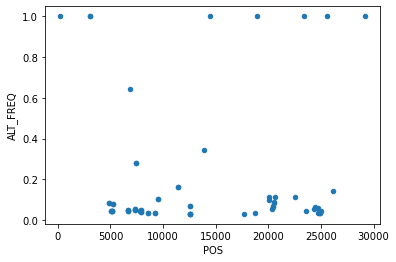

In [105]:
df.plot(x='POS', y='ALT_FREQ', kind='scatter')